In [207]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image
import math
from ipywidgets import interact, widgets

import skimage

from DiffuserCamUtils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [228]:
def initialize(image_file, psf_file, f_lat = 1, f_ax = 1, type = 'pco', color = 'rgb', dim = '2d'):
    try:
        im_type = image_file[-3:]
        psf_type = psf_file[-3:]
        #image = rgb2gray(np.array(Image.open(image_file)))
        image = np.array(Image.open(image_file))
        image = np.sum(image, 2)

        #psf = io.loadmat(psf_file)['psf'] if psf_type == 'mat' else rgb2gray(np.array(Image.open(psf_file)))
        psf = io.loadmat(psf_file)['psf'] if psf_type == 'mat' else np.array(Image.open(psf_file))
        psf = np.sum(psf, 2)
        
    except IOError as ex:
        print("I/O error: " + str(ex.strerror))
    
    
    if dim == '2d':         #embed into a 3d array
        psf = np.expand_dims(psf, 2)
        
    psf_mean = np.mean(np.random.choice(psf.flatten('C'),(15,15))) #102
    psf_bg = 0
    image_bg = psf_bg #should be around 100

    
    #psf_down = downsample_ax(psf - psf_bg, f_lat)
    #image = downsample_ax(image - image_bg, f_lat)
    
    psf_down = skimage.transform.resize(psf - psf_bg, (psf.shape[0]//f_lat, psf.shape[1]//f_lat),
                                    mode="constant", anti_aliasing=True)
    image = skimage.transform.resize(image - image_bg, (image.shape[0]//f_lat, image.shape[1]//f_lat),
                                    mode="constant", anti_aliasing=True)
    
    
    show_data(image, image)
    
   
    print(image.shape)
    image_copy = np.copy(image)
    padded = np.full(psf_down.shape[:2], psf_mean)
    padded[psf_down.shape[0]//2 - image.shape[0]//2: psf_down.shape[0]//2 + image.shape[0]//2,
            psf_down.shape[1]//2 - image.shape[1]//2: psf_down.shape[1]//2 + image.shape[1]//2] = image_copy
    image = padded
    print(image.shape)
    print(psf_down.shape)

    if dim == '3d':
        psf_down = downsample_lat(psf_down, f_ax)

    psf_down /= norm(psf_down)
    image /= np.max(image)

    return psf_down, image


In [229]:
#gt_file = 'C:/Users/Deshler/Desktop/MS DiffuserCam - 2D Recon Pipeline/Prototype 2D Recon/2DScenes/num_srcs_5/ground_truth.png'
#gt_image = rgb2gray(np.array(Image.open(gt_file)))
#gt_image = np.array(Image.open(gt_file))

<IPython.core.display.Javascript object>


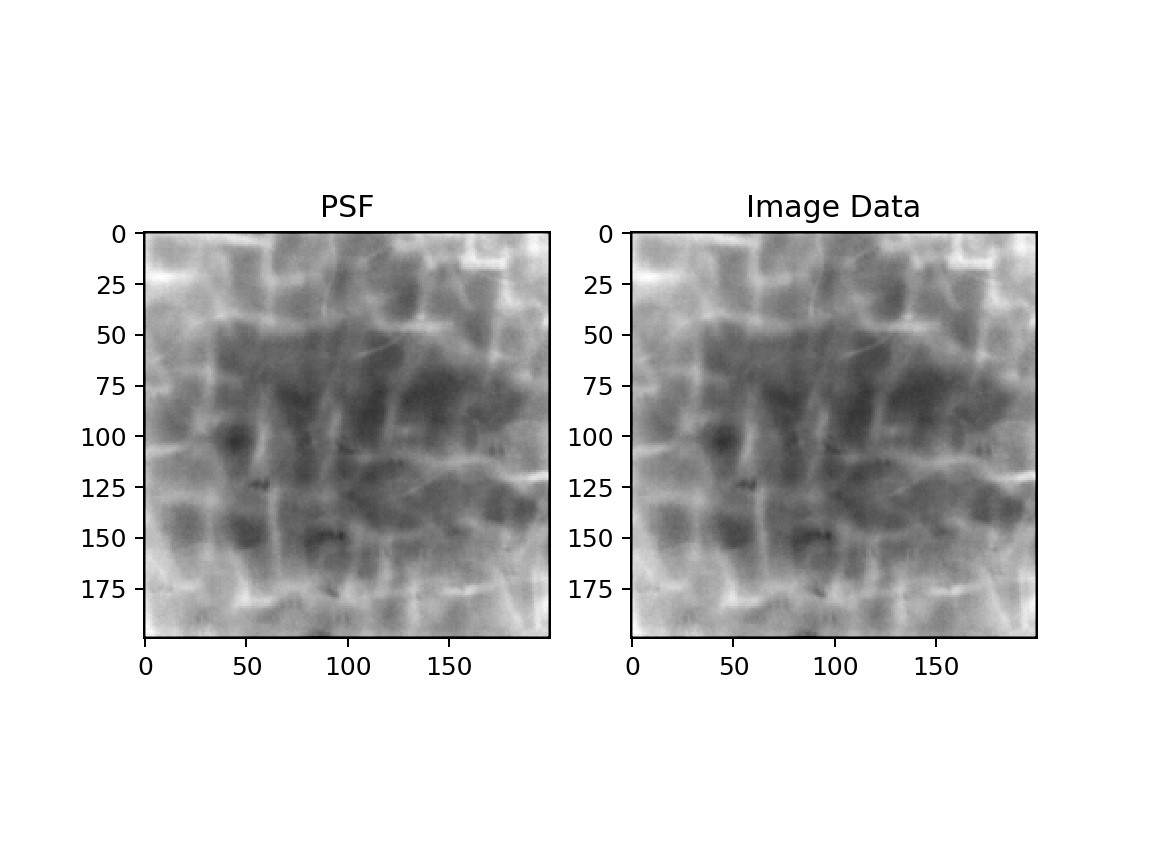

(200, 200)
(250, 250)
(250, 250, 1)


In [230]:
dimensions = '2d'
psf_file = '/Users/Ellin/Prototype-DiffuserCam/2D-Recon-Pipeline/small_cal_recon/PSF_square_crop.png'
#psf_file = '/Users/Ellin/Prototype-DiffuserCam/2D-Recon-Pipeline/small_cal_recon/PSF_single_cam.png'
image_file = '/Users/Ellin/Prototype-DiffuserCam/2D-Recon-Pipeline/small_cal_recon/small_cal_measurement_single_cam_crop.png'
#image_file = '/Users/Ellin/Prototype-DiffuserCam/2D-Recon-Pipeline/small_cal_recon/PSF_single_cam.png'

psf, b = initialize(image_file, psf_file, dim = dimensions, f_lat = 4)
#psf -= np.min(psf)
#b -= np.min(b)

r = 0.5    #proportion of pixels to crop out
num_cropped = int(r * b.size)
crop2d, crop3d, pad2d, pad3d, pix_crop = get_crop_pad(psf, N = num_cropped)
h = pad2d(psf)    #pad the input stack of h's

obj_shape = h.shape
up_shape = psf.shape
A, AH = get_ops(h, crop2d, pad2d, crop3d, pad3d, up_shape)

<IPython.core.display.Javascript object>


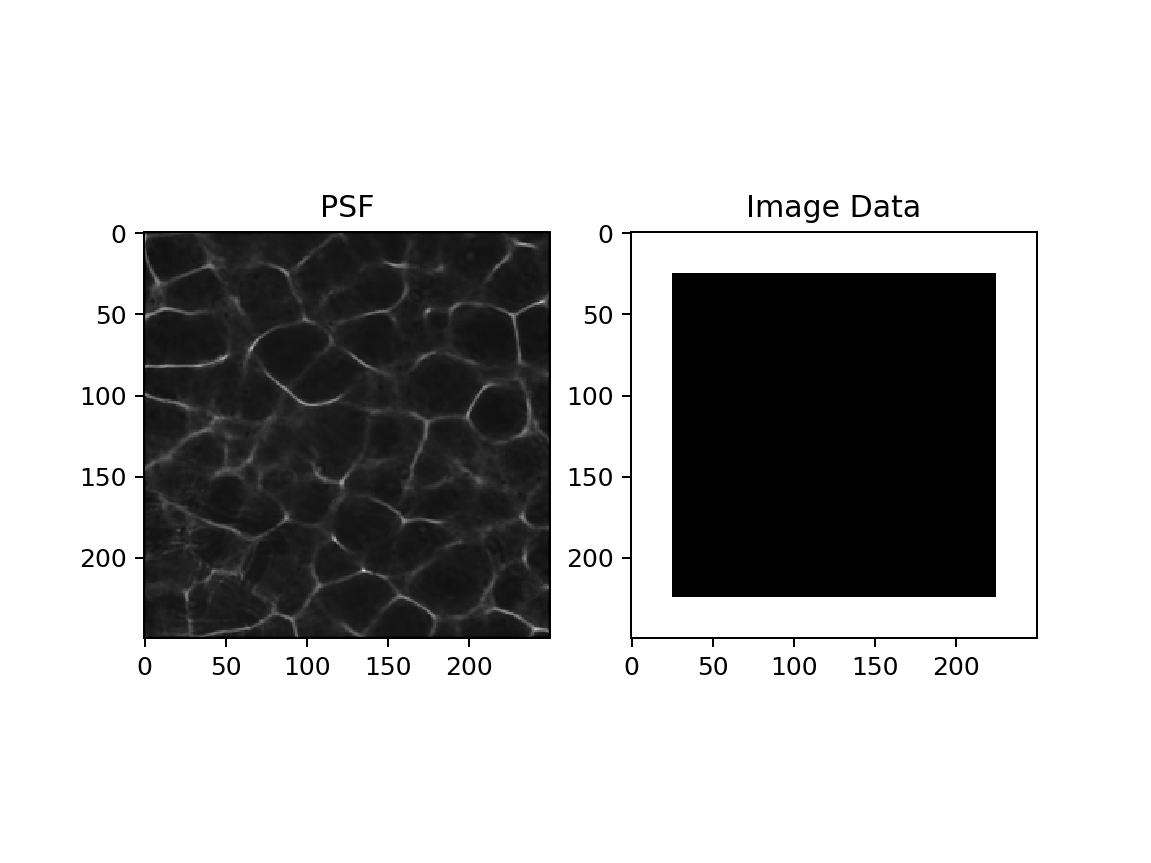

In [231]:
show_data(np.real(psf[:, :, 0]), b)

In [169]:
#setup parameters
alg = 'admm'
max_itr = 200
opt = Options(dimensions, alg, max_itr)
#opt.gamma = np.real(1.8 / np.max(Hstar * H))
opt.gamma = 1
#opt.eps = 7.4e-3        #7.4e-3 for nesterov, 4e-3 for fista
opt.del_pixels = True
opt.psf = h
opt.b = b
opt.crop2d, opt.pad2d = crop2d, pad2d
opt.crop3d, opt.pad3d = crop3d, pad3d
opt.up_shape, opt.pad_shape = up_shape, obj_shape
opt.autotune = True
opt.beta = 1.1
opt.alpha = 1.01

# tune regularization parameters.
# 2d tuning: default to 1e-4 on each, tau = 2e-3
# cartoony: 1e-3, 5e-2, 1e-3, 2e-5
# to actually see cost function going down, use tau = 1, other mu's = 1e-4
opt.mu1 = 1e-4
opt.mu2 = 1e-4
opt.mu3 = 1e-4
opt.tau = 2e-3

In [170]:
grad_func = lambda x : grad(x, A, AH, b)
error = lambda x : objective(x, A, b, opt.tau)

<IPython.core.display.Javascript object>


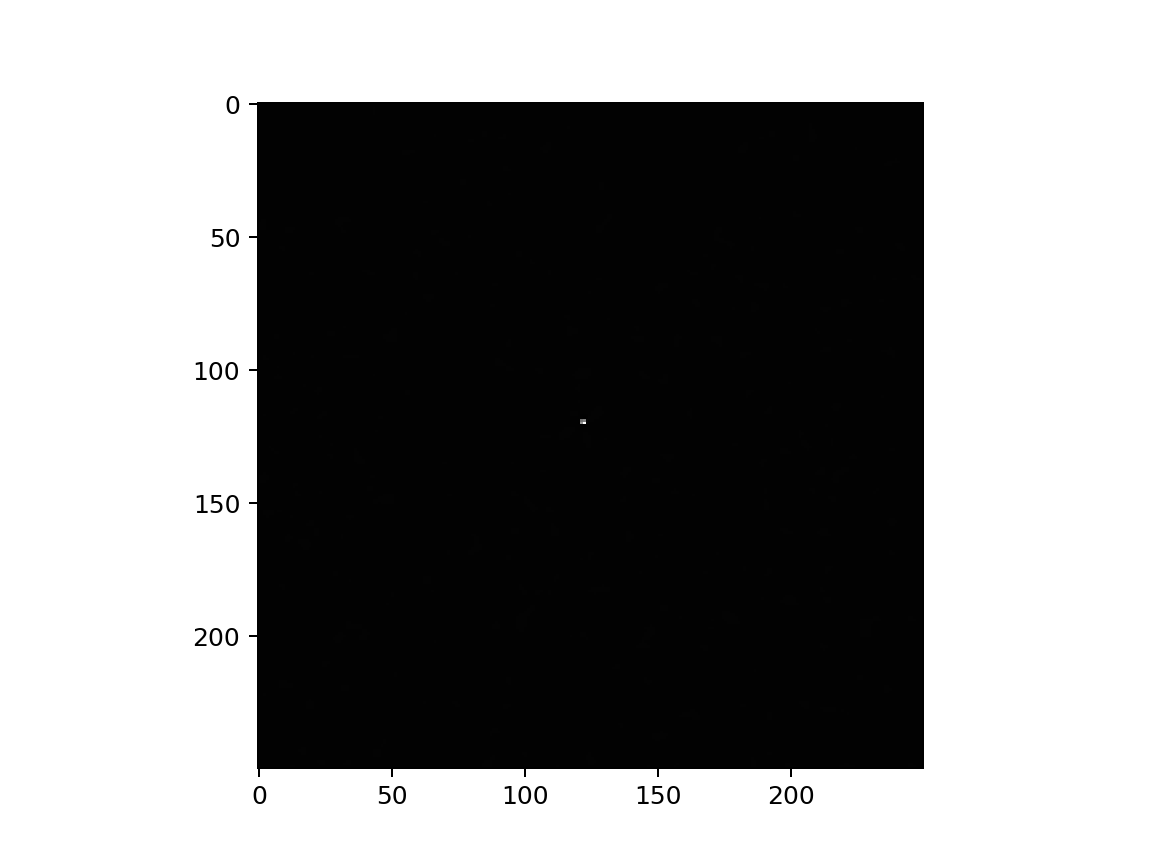

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [171]:
x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

<IPython.core.display.Javascript object>


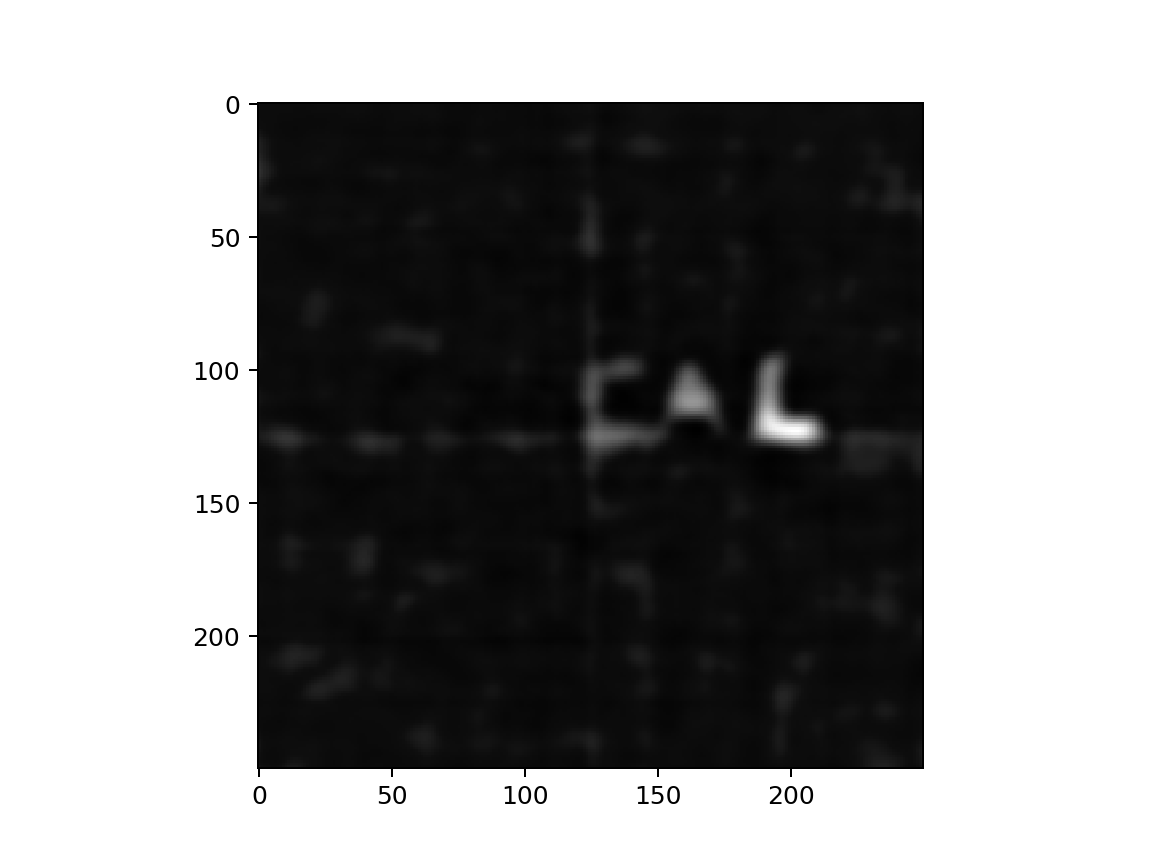

mu1 = 0.0001, mu2 = 0.0001, mu3 = 0.0001, tau = 0.002
Autotuning with alpha = 1.01, beta = 1.1
Iteration number 20. mu1: 1.2e-04. mu2: 1.2e-04. mu3: 1.2e-04
Iteration number 40. mu1: 1.5e-04. mu2: 1.5e-04. mu3: 1.5e-04
Iteration number 60. mu1: 1.8e-04. mu2: 1.8e-04. mu3: 1.8e-04
Iteration number 80. mu1: 2.2e-04. mu2: 2.2e-04. mu3: 2.2e-04
Iteration number 100. mu1: 2.7e-04. mu2: 2.7e-04. mu3: 2.7e-04
Iteration number 120. mu1: 3.3e-04. mu2: 3.3e-04. mu3: 3.3e-04
Iteration number 140. mu1: 4.1e-04. mu2: 4.1e-04. mu3: 4.1e-04
Iteration number 160. mu1: 5.0e-04. mu2: 5.0e-04. mu3: 5.0e-04
Iteration number 180. mu1: 6.1e-04. mu2: 6.1e-04. mu3: 6.1e-04


In [15]:
x, error_list = solver(grad_func, error, non_negative, opt)
x = crop2d(x)

In [ ]:
#plt.figure(figsize=(10,4));
#plt.subplot(1,2,1), plt.imshow(gt_image, cmap='gray'), plt.axis('off'); plt.title('gt camera')
#plt.subplot(1,2,2), plt.imshow(x[:,:,0], cmap='gray'), plt.axis('off'); plt.title('DiffuserCam')

In [ ]:
#%matplotlib inline
#plt.figure(figsize=(10,4));
#plt.imshow(x[:,:,0]);